# FINM 250 Homework 2
### TA Solutions

**Note:** in this notebook, pay close attention to how virtually all of my code is functionalized. This is a good habit to get into, and will save you a lot of time on the midterm. By having a lot of different functions, I'm able to complete the entire assignment with (excluding multi-line statements for formatting purposes) 25 lines of code *total*. If I further exclude plotting/displaying code to make the answers look nice, the "core" code is only 12-15 lines long.

## Part 2

In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt

# Plotting settings.
plt.rcParams["axes.grid"] = True
plt.rcParams["axes.spines.right"] = False
plt.rcParams["axes.spines.top"] = False

# Pandas settings.
pd.set_option("display.float_format", lambda x: "{:.4f}".format(x))

# Constants for risk metrics, return metrics, and annualization.
RETURN_COLS = ["Annualized Return", "Annualized Volatility", "Annualized Sharpe Ratio"]
RISK_COLS = [
    "Skewness",
    "Excess Kurtosis",
    "VaR (0.05)",
    "CVaR (0.05)",
    "Max Drawdown",
    "Bottom",
    "Peak",
    "Recovery",
    "Duration (days)",
]
ADJ = 12


def calc_return_metrics(data, as_df=False, adj=12):
    """
    Calculate return metrics for a given dataset. Specifically:
    - Annualized Return
    - Annualized Volatility
    - Annualized Sharpe Ratio
    - Annualized Sortino Ratio (not part of the course, but useful to know)

    Args:
        data : Returns time series.
        as_df (bool, optional): Return a df or dict. Defaults to False.
        adj (int, optional): Annualization. Defaults to 12.

    Returns:
        DataFrame or dict: Summary of return metrics.
    """
    summary = dict()
    summary["Annualized Return"] = data.mean() * adj
    summary["Annualized Volatility"] = data.std() * np.sqrt(adj)
    summary["Annualized Sharpe Ratio"] = (
        summary["Annualized Return"] / summary["Annualized Volatility"]
    )
    summary["Annualized Sortino Ratio"] = (
        summary["Annualized Return"] * np.sqrt(adj) / (data[data < 0].std())
    )

    # Here, we use what is known as a "ternary operator", usually denoted as "condition ? if_true : if_false",
    # in other programming languages. This is equivalent to having an explicit if-else statement, but is more
    # concise and can be written on a single line.
    return pd.DataFrame(summary, index=data.columns) if as_df else summary


def calc_risk_metrics(data, as_df=False, adj=12):
    """
    Calculate risk metrics for a given dataset. Specifically:
    - Skewness
    - Kurt
    - VaR (0.05)
    - CVaR (0.05)
    - Max Return in a single period
    - Min Return in a single period
    - Peak
    - Max Drawdown
    - Bottom (of drawdown)
    - Recovery (of drawdown)

    Args:
        data : Returns time series.
        as_df (bool, optional): Return a df or a dictionary. Defaults to False.
        adj (int, optional): Annualization. Defaults to 12.

    Returns:
        DataFrame or Dictionary: Summary of risk metrics.
    """
    summary = dict()
    summary["Skewness"] = data.skew()
    summary["Excess Kurtosis"] = data.kurtosis()
    summary["VaR (0.05)"] = data.quantile(0.05, axis=0)
    summary["CVaR (0.05)"] = data[data <= data.quantile(0.05, axis=0)].mean()
    summary["Min"] = data.min()
    summary["Max"] = data.max()

    # Cumulative returns on $1000
    wealth_index = 1000 * (1 + data).cumprod()

    previous_peaks = wealth_index.cummax()

    # Biggest difference between cumulative max and your current wealth
    drawdowns = (wealth_index - previous_peaks) / previous_peaks

    summary["Max Drawdown"] = drawdowns.min()

    summary["Peak"] = previous_peaks.idxmax()
    summary["Bottom"] = drawdowns.idxmin()

    recovery_date = []
    for col in wealth_index.columns:
        prev_max = previous_peaks[col][: drawdowns[col].idxmin()].max()
        recovery_wealth = pd.DataFrame([wealth_index[col][drawdowns[col].idxmin() :]]).T
        recovery_date.append(
            recovery_wealth[recovery_wealth[col] >= prev_max].index.min()
        )

    # Here, we use a list comprehension to check if the recovery date is null,
    # meaning that the drawdown has not yet recovered.
    summary["Recovery"] = ["-" if pd.isnull(i) else i for i in recovery_date]

    # Note that here we use the zip() function to iterator over two lists at the same time.
    # This is equivalent to using a for loop over the indices of the lists, and then getting
    # the values at those indices.
    summary["Duration (days)"] = [
        (i - j).days if i != "-" else "-"
        for i, j in zip(summary["Recovery"], summary["Bottom"])
    ]

    return pd.DataFrame(summary, index=data.columns) if as_df else summary


def calc_perf_metrics(data, adj=12):
    """
    Calculate performance metrics for a given dataset.

    Args:
        data : Returns time series.
        adj (int, optional): Annualization. Defaults to 12.

    Returns:
        DataFrame: Summary of performance metrics.
    """
    # This is a more advanced Python concept, known as "dictionary unpacking".
    # It is equivalent to joining the two dictionaries together using a for loop
    # over the keys, but is much more concise.

    # There is a similar concept for lists, known as "list unpacking" or "iterator unpacking",
    # as it works for any iterable object. We use this via tha *list operator. So, if we
    # wanted to join two lists together, we would do: list3 = [*list1, *list2].

    summary = {**calc_return_metrics(data, adj), **calc_risk_metrics(data, adj)}
    summary["Calmar Ratio"] = summary["Annualized Return"] / abs(
        summary["Max Drawdown"]
    )
    return pd.DataFrame(summary, index=data.columns)


def calc_univ_regr(y, X, intercept=True, adj=12):
    """
    Calculate a univariate regression of y on X. Note that both X and y
    need to be one-dimensional.

    Args:
        y : target variable
        X : independent variable
        intercept (bool, optional): Fit the regression with an intercept or not. Defaults to True.
        adj (int, optional): What to adjust the returns by. Defaults to 12.

    Returns:
        DataFrame: Summary of regression results
    """
    X_down = X[X < 0]
    y_down = y[X < 0]
    if intercept:
        X = sm.add_constant(X)
        X_down = sm.add_constant(X_down)

    model = sm.OLS(y, X, missing="drop")
    results = model.fit()

    # More ternary operators.
    inter = results.params[0] if intercept else 0
    beta = results.params[1] if intercept else results.params[0]

    summary = dict()

    summary["Alpha"] = inter * adj
    summary["Beta"] = beta

    # Note: Downside Beta is not part of the course, but is a useful metric to know.
    down_mod = sm.OLS(y_down, X_down, missing="drop").fit()
    summary["Downside Beta"] = down_mod.params[1] if intercept else down_mod.params[0]

    summary["R-Squared"] = results.rsquared
    summary["Treynor Ratio"] = (y.mean() / beta) * adj
    summary["Information Ratio"] = (inter / results.resid.std()) * np.sqrt(adj)
    summary["Tracking Error"] = (
        inter / summary["Information Ratio"]
        if intercept
        else results.resid.std() * np.sqrt(adj)
    )

    return pd.DataFrame(summary, index=[y.name])


def calc_multi_regr(y, X, intercept=True, adj=12):
    """
    Calculate a multivariate regression of y on X. Adds useful metrics such
    as the Information Ratio and Tracking Error. Note that we can't calculate
    Treynor Ratio or Downside Beta here.

    Args:
        y : target variable
        X : independent variables
        intercept (bool, optional): Defaults to True.
        adj (int, optional): Annualization factor. Defaults to 12.

    Returns:
        DataFrame: Summary of regression results
    """
    if intercept:
        X = sm.add_constant(X)

    model = sm.OLS(y, X, missing="drop")
    results = model.fit()
    summary = dict()

    inter = results.params[0] if intercept else 0
    betas = results.params[1:] if intercept else results.params

    summary["Alpha"] = inter * adj
    summary["R-Squared"] = results.rsquared

    X_cols = X.columns[1:] if intercept else X.columns

    for i, col in enumerate(X_cols):
        summary[f"{col} Beta"] = betas[i]

    summary["Information Ratio"] = (inter / results.resid.std()) * np.sqrt(adj)
    summary["Tracking Error"] = (
        inter / summary["Information Ratio"]
        if intercept
        else results.resid.std() * np.sqrt(adj)
    )
    return pd.DataFrame(summary, index=[y.name])


def calc_iter_regr(y, X, intercept=True, one_to_many=False, adj=12):
    """
    Iterative regression for checking one X column against many different y columns,
    or vice versa. "one_to_many=True" means that we are checking one X column against many
    y columns, and "one_to_many=False" means that we are checking many X columns against a
    single y column.

    Args:
        y : Target variable(s)
        X : Independent variable(s)
        intercept (bool, optional): Defaults to True.
        one_to_many (bool, optional): Which way to run the regression. Defaults to False.
        adj (int, optional): Annualization. Defaults to 12.

    Returns:
        DataFrame : Summary of regression results.
    """
    if one_to_many:
        summary = pd.concat(
            [calc_univ_regr(y[col], X, intercept, adj) for col in y.columns], axis=0
        )
        summary.index = y.columns
        return summary
    else:
        summary = pd.concat(
            [calc_univ_regr(y, X[col], intercept, adj) for col in X.columns], axis=0
        )
        summary.index = X.columns
        return summary


def plot_corr_matrix(corrs):
    # Correlation helper function.
    return sns.heatmap(
        corrs,
        annot=True,
        cmap="coolwarm",
        vmin=-1,
        vmax=1,
        linewidths=0.7,
        annot_kws={"size": 10},
        fmt=".2f",
        square=True,
        cbar_kws={"shrink": 0.75},
    )


def print_max_min_corr(corrs):
    # Correlation helper function.
    corr_series = corrs.unstack()
    corr_series = corr_series[corr_series != 1]

    max_corr = corr_series.abs().agg(["idxmax", "max"]).T
    min_corr = corr_series.abs().agg(["idxmin", "min"]).T
    min_corr_raw = corr_series.agg(["idxmin", "min"]).T
    max_corr, max_corr_val = max_corr["idxmax"], max_corr["max"]
    min_corr, min_corr_val = min_corr["idxmin"], min_corr["min"]
    min_corr_raw, min_corr_raw_val = min_corr_raw["idxmin"], min_corr_raw["min"]

    print(
        f"Max Corr (by absolute value): {max_corr[0]} and {max_corr[1]} with a correlation of {max_corr_val:.2f}"
    )
    print(
        f"Min Corr (by absolute value): {min_corr[0]} and {min_corr[1]} with a correlation of {min_corr_val:.2f}"
    )
    print(
        f"Min Corr (raw): {min_corr_raw[0]} and {min_corr_raw[1]} with a correlation of {min_corr_raw_val:.2f}"
    )


# Those who read through the "How to Avoid Typing the Same Variables Over and Over Again" section
# of TA Review number 2 (https://github.com/MarkHendricks/finm-quant-2024/blob/main/reviews/TA_Review_2.ipynb)
# which I skipped to save for later, may notice that this is a great place for a partial function.

# Load data.

from functools import partial

get_data = partial(
    pd.read_excel, "../data/proshares_analysis_data.xlsx", index_col=0, parse_dates=[0]
)

rets_hf = get_data(sheet_name="hedge_fund_series")
rets_ml = get_data(sheet_name="merrill_factors")
rets_hf["SPY US Equity"] = rets_ml["SPY US Equity"]
rets_other = get_data(sheet_name="other_data")

### 1

In [2]:
calc_perf_metrics(rets_hf)[["Annualized Return", "Annualized Volatility", "Annualized Sharpe Ratio"]]

,Annualized Return,Annualized Volatility,Annualized Sharpe Ratio
HFRIFWI Index,0.0474,0.0601,0.7889
MLEIFCTR Index,0.0346,0.0565,0.6124
MLEIFCTX Index,0.0330,0.0564,0.5848
HDG US Equity,0.0233,0.0588,0.3967
QAI US Equity,0.0235,0.0504,0.4649
SPY US Equity,0.1394,0.1466,0.9508


### 2

In [3]:
calc_perf_metrics(rets_hf)[['Skewness', 'Excess Kurtosis', 'VaR (0.05)',
       'CVaR (0.05)', 'Min', 'Max', 'Max Drawdown', 'Bottom', 'Peak',
       'Recovery', 'Duration (days)', 'Calmar Ratio']]

,Skewness,Excess Kurtosis,VaR (0.05),CVaR (0.05),Min,Max,Max Drawdown,Bottom,Peak,Recovery,Duration (days),Calmar Ratio
HFRIFWI Index,-0.9455,5.5911,-0.0246,-0.0375,-0.0908,0.0586,-0.1155,2020-03-31,2024-05-31,2020-08-31 00:00:00,153,0.4109
MLEIFCTR Index,-0.2548,1.5983,-0.0283,-0.0359,-0.0532,0.0589,-0.1243,2022-09-30,2024-05-31,2024-02-29 00:00:00,517,0.2785
MLEIFCTX Index,-0.2401,1.5605,-0.0284,-0.0358,-0.0524,0.0588,-0.1244,2022-09-30,2024-05-31,2024-02-29 00:00:00,517,0.2651
HDG US Equity,-0.2488,1.7334,-0.0310,-0.0376,-0.0592,0.0583,-0.1407,2022-09-30,2021-06-30,-,-,0.1657
QAI US Equity,-0.4028,1.5403,-0.0186,-0.0327,-0.0563,0.0398,-0.1377,2022-09-30,2024-05-31,2024-02-29 00:00:00,517,0.1703
SPY US Equity,-0.3897,0.6543,-0.0656,-0.0867,-0.1249,0.1270,-0.2393,2022-09-30,2024-05-31,2023-12-31 00:00:00,457,0.5826


### 3

In [4]:
spy = rets_ml["SPY US Equity"]
regression_metrics = calc_iter_regr(rets_hf, spy, one_to_many=True)
regression_metrics.iloc[:-1, :]

,Alpha,Beta,Downside Beta,R-Squared,Treynor Ratio,Information Ratio,Tracking Error
HFRIFWI Index,-0.0010,0.3472,0.3987,0.7166,0.1366,-0.0300,0.0027
MLEIFCTR Index,-0.0134,0.3444,0.3805,0.7980,0.1005,-0.5273,0.0021
MLEIFCTX Index,-0.0149,0.3432,0.3764,0.7965,0.0961,-0.5846,0.0021
HDG US Equity,-0.0259,0.3534,0.3983,0.7766,0.0660,-0.9334,0.0023
QAI US Equity,-0.0182,0.2985,0.2856,0.7525,0.0786,-0.7235,0.0021


### 4

Differences between SPY and hedge fund series:

I think that overall, it depends, although these metrics are *heavily* skewed in the favor of SPY. Specifically, SPY has a higher Sharpe ratio, lower excess skewness, and lower kurtosis. This means that SPY has a better risk-return profile from looking at the moments of the distribution. However, the hedge fund series does have less than half of the volatility of SPY, as well as much better VaR, CVaR, and drawdown metrics (1/3rd the VaR/CVaR, and 1/2 the drawdown). This could suggest that SPY has more tail events than the hedge fund series. Something else worth noting is that they are highly correlated, with an r^2 of 0.7, and so investors are not really getting much diversification from the HFRI series.

HDG vs. QAI

QAI is marginally better on most fronts, with the exception of skewness. However, there is not a huge difference between the two, and in fact they are highly correlated (from Q5). One benefit potentially of QAI is that is has a slightly lower r^2 to the market (0.75 vs. 0.77), and a slightly lower downside beta. Overall, I think QAI is better, but not due to any major differences, just marginally "wins" over HDG across the board.

Whether HDG and ML series capture the most notable properties of HFRI:

Yes, definitely. We will see this more in Q6 and Q7 when we replicate HFRI using the factors, but, looking at the different risk measures and market correlations, they are very similar. Though, one notably difference is the skewness and kurtosis, which is much higher for HFRI than the 2 Merrill Factors. HFRI also has a slightly better Sharpe ratio.



### 5

<AxesSubplot:>

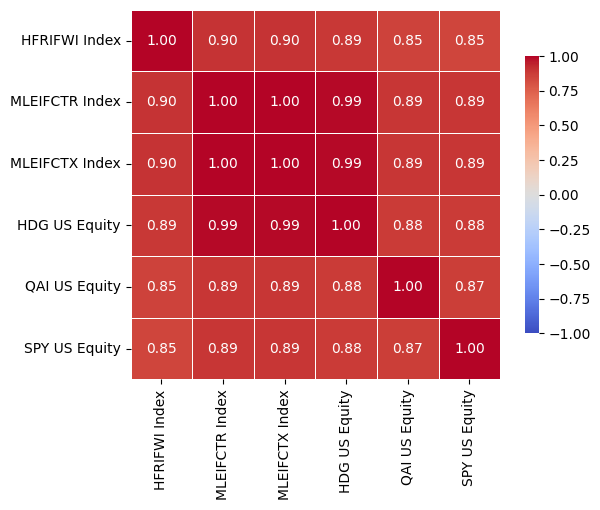

In [5]:
plot_corr_matrix(rets_hf.corr())

It's bright red! All of these series are very highly correlated. We see that HFRIFWI and spy have the lowest correlation (~0.85), and then the 2 Merrill Factors have the highest correlation. The later is to be expected, given that they are basically the same thing. The former is a little surprising, given that theoretically if the hedge funds in HFRI were uncorrelated (hedged!) to the market, we would expect the correlation to be close to zero.

### 6.a

In [6]:
model = sm.OLS(endog=rets_hf["HFRIFWI Index"], exog=sm.add_constant(rets_ml)).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          HFRIFWI Index   R-squared:                       0.841
Model:                            OLS   Adj. R-squared:                  0.834
Method:                 Least Squares   F-statistic:                     129.4
Date:                Tue, 01 Jul 2025   Prob (F-statistic):           4.43e-56
Time:                        18:52:55   Log-Likelihood:                 547.72
No. Observations:                 154   AIC:                            -1081.
Df Residuals:                     147   BIC:                            -1060.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0012      0.001      1.641      0.103      -0.000       0.003
SPY US Equity     0.0312      0.036      0.867      0.387      -0.040       0.102
USGG3M Index      0.2419      0.404      0.598      0.550      -0.557       1.041
EEM US Equity     0.0799      0.021      3.819      0.000       0.039       0.121
EFA US Equity     0.0844      0.036      2.378      0.019       0.014       0.155
EUO US Equity     0.0278      0.017      1.623      0.107      -0.006       0.062
IWM US Equity     0.1508      0.022      6.921      0.000       0.108       0.194
==============================================================================
Omnibus:                       23.074   Durbin-Watson:                   1.918
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               76.494
Skew:                          -0.464   Prob(JB):                     2.45e-17
Kurtosis:                       6.326   Cond. No.                         710.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [7]:
model.params.sum()

0.6172880220493228

### 6.b

No, none of the position sizes are huge, ranging between 0.02 and 0.24, additionally, they don't sum to 1 (0.61). Even if we were to rescale to sum to 1, they would still be mostly reasonable. None require a short position.


### 6.c

In [8]:
model.rsquared

0.8407844766232782

### 6.d

In [9]:
model.resid.std()

0.006927331624206004

### 7

OOS-R-Squared: 81.20%


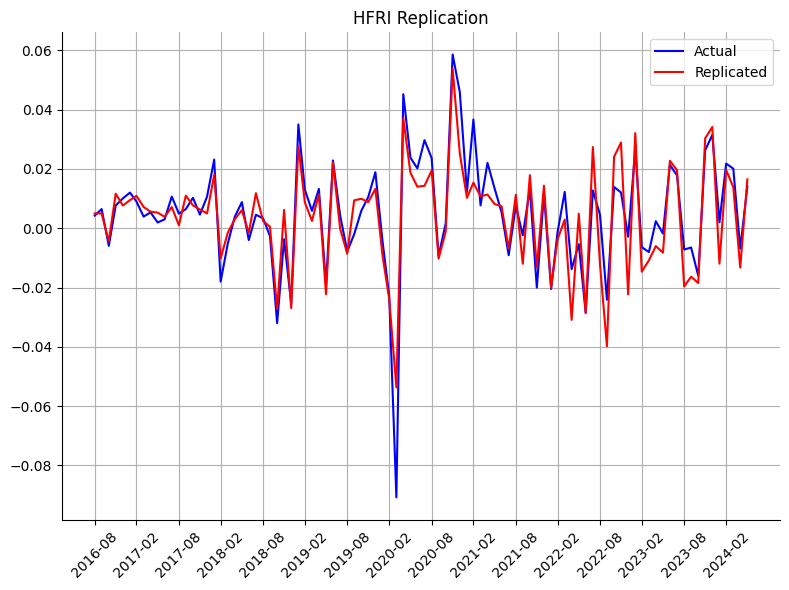

In [10]:
# Here, we use a new Python concept, called a defaultdict. This is a dictionary that
# automatically creates a new key if it doesn't exist. We can pass it a type in the constructor,
# and it will create a new key with that type if it doesn't exist and then we can interact with
# it as if it were a normal dictionary. So, since we have a list, we can do summary[key].append(value),
# without having to first do summary[key] = [].
from collections import defaultdict

summary = defaultdict(list)


for idx in range(60, len(rets_hf), 1):
    # Get the data for ML factors and HFRI
    X = rets_ml.iloc[idx - 60 : idx].copy()
    y = rets_hf.iloc[idx - 60 : idx, 0].copy()

    oos_y = rets_hf.iloc[idx, 0]
    oos_X = rets_ml.iloc[idx, :].copy()

    # Calculate the regression coefficients
    regr = sm.OLS(y, sm.add_constant(X), missing="drop").fit()

    for jdx, coeff in enumerate(regr.params.index):
        summary[coeff].append(regr.params[jdx])

    # Get predicted y by multiplying the coefficients by the X values and
    # adding the intercept
    y_pred = regr.params[0] + (regr.params[1:] @ oos_X)

    summary["Replicated"].append(y_pred)
    summary["Actual"].append(oos_y)


summary = pd.DataFrame(summary, index=rets_hf.index[60:])

# Calculate OOS R-Squared
oos_rsquared = (
    1 - (summary["Actual"] - summary["Replicated"]).var() / summary["Actual"].var()
)
print(f"OOS-R-Squared: {oos_rsquared:.2%}")

fig, ax = plt.subplots(figsize=(8, 6))

ax.plot(summary.index, summary["Actual"], label="Actual", color="blue")
ax.plot(summary.index, summary["Replicated"], label="Replicated", color="red")
ax.grid(True)
ax.legend()

# Make ticklabels every 6 months and label them as %yyy-%mm
ax.set_xticks(summary.index[::6])
ax.set_xticklabels(
    [f"{i.year}-{i.month:02d}" for i in summary.index[::6]],
    rotation=45,
    horizontalalignment="center",
)

ax.set_title("HFRI Replication")
fig.tight_layout()

It does an extremely good job of replicating, with an out-of-sample R-squared of 80%!